# SOMMAIRE

## [I - Import des fichiers et librairies](#ch1)

## [II - Preprocessing](#ch2)

## [III - ](#ch3)

<a id="ch1"></a>
# I : Import des fichiers et librairies

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import fr_core_news_md

# N - grams
from nltk.util import ngrams
from collections import Counter
from wordcloud import WordCloud

# Others
from collections import Counter
import time
from tqdm import tqdm 

In [25]:
file = r'D:\PROD_SAS\03_Projets_CRM\48_Malakoff_Humanis\ANALYSE_SATISFACTION\01_data\files\malakoff_july.xlsx'
temp = pd.read_excel(file, sheet_name = 'EXTRACT')

In [26]:
# On conserve les colonnes verbatim

data = temp[['REMERCIEMENTS_verbatim', 'VERBATIM_AMELIORATION_verbatim', "SATISFACTION_GLOBALE"]]

# Suppression des NaN
data.dropna(subset = ['REMERCIEMENTS_verbatim', 'VERBATIM_AMELIORATION_verbatim'], how= "all", inplace = True)

data.columns = ["remerciements", "amelioration", "sat"]

C:\Users\MONOD002\AppData\Local\Temp\4\ipykernel_12352\2109026010.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(subset = ['REMERCIEMENTS_verbatim', 'VERBATIM_AMELIORATION_verbatim'], how= "all", inplace = True)


In [27]:
pourcentage_lignes_rens = round(data.shape[0] / temp.shape[0] * 100, 1)
print(f"{data.shape[0]} verbatims ont été renseignés, pour {temp.shape[0]} appels, soit {pourcentage_lignes_rens}%.") 

12066 verbatims ont été renseignés, pour 281476 appels, soit 4.3%.


In [28]:
data.head()

,remerciements,amelioration,sat
28,J obtiens toujours les réponses à mes questions,Pas d avis,9.0
31,Interlocutrice à l'écoute et aimable.,Le temps d'attente :),9.0
43,NaN,Ne changez rien…,10.0
44,Elle m'a un peu rassuré car je n'avais pas reç...,NaN,10.0
70,RAS,Globalement dans l'ensemble satisfaisant,7.0


<a id="ch2"></a>
## II - Preprocessing

In [29]:
# ATTENTION DOCU IMPORTANTE !! IL Y AVAIT DES PBS D'IMPORT, ET LE CODE A MARCHE QUAND QUAND AU LIEU DE 
# pip install fr_core_news_sm J'AI FAIT pip --user install fr_core_news_sm PUIS QUE J'AI REFAIT pip  install fr_core_news_sm
# Pareil pour fr_core_news_md
# Ou bien avec le lien dispo sur https://spacy.io/models/fr
import fr_core_news_md
nlp = fr_core_news_md.load()

def cleanTextToken(text):
    ''' standardize text to extract words
    '''
    text = str(text)
    # text to lowercase
    text = text.lower()
    # remove numbers
    text = ''.join([i for i in text if not i.isdigit()])
    # remove punctuation
    tokenizer = RegexpTokenizer(r'\w+') # preserve words and alphanumeric
    text = tokenizer.tokenize(text)
    # remove stopwords
    stop = set(stopwords.words('french'))
    text = [w for w in text if w not in stop]
    return(text)


In [30]:
# Les librairies de stopwords sont incomplètes : j'en merge deux
from spacy.lang.fr.stop_words import STOP_WORDS as sw_spacy
sw_nltk = nltk.corpus.stopwords.words('french')

set_sw_spacy = set(sw_spacy)
set_sw_nltk = set(sw_nltk)
all_stopwords = set_sw_spacy.union(set_sw_nltk)

In [31]:
def cleanTextToken(text):
    ''' standardize text to extract words
    '''
    # text to lowercase
    text = text.lower()
    # remove numbers
    text = ''.join([i for i in text if not i.isdigit()])
    # remove punctuation
    from nltk.tokenize import RegexpTokenizer
    tokenizer = RegexpTokenizer(r'\w+') # preserve words and alphanumeric
    text = tokenizer.tokenize(text)
    # remove stopwords
    #stop = nltk.corpus.stopwords.words('french')
    text = [w for w in text if w not in all_stopwords]
    
    doc = nlp(" ".join(text))
    text = [token.lemma_ for token in doc]

    # lemmatization
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(word) for word in text]
    return(text)

In [32]:
# Psce de floats... Donc on convertit toute la col en str
data["to_lemmatize"] = data.remerciements.astype(str)
data['remerciements_token'] = data.to_lemmatize.apply(cleanTextToken)
data.drop(columns="to_lemmatize", inplace=True)

C:\Users\MONOD002\AppData\Local\Temp\4\ipykernel_12352\1793132935.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["to_lemmatize"] = data.remerciements.astype(str)
C:\Users\MONOD002\AppData\Local\Temp\4\ipykernel_12352\1793132935.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['remerciements_token'] = data.to_lemmatize.apply(cleanTextToken)
C:\ProgramData\Python38\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [33]:
# Vérification des mots lemmatizés - y a-t-il encore des stopwords ?
# Tester autres bibliothèques stopwords french

liste = []
for i in data.remerciements_token:
    liste.extend(i)

Counter(liste).most_common()

[('réponse', 2929),
 ('demande', 2116),
 ('attente', 1262),
 ('conseiller', 1167),
 ('question', 1165),
 ('bien', 1035),
 ('bon', 1018),
 ('clair', 1017),
 ('service', 1001),
 ('répondre', 982),
 ('écoute', 978),
 ('nan', 936),
 ('problème', 896),
 ('interlocuteur', 841),
 ('remboursement', 771),
 ('temp', 724),
 ('appel', 709),
 ('accueil', 704),
 ('minute', 696),
 ('aimable', 666),
 ('long', 666),
 ('téléphone', 663),
 ('faire', 653),
 ('agréable', 653),
 ('recevoir', 621),
 ('fois', 608),
 ('rapide', 605),
 ('aucun', 588),
 ('dossier', 582),
 ('mail', 565),
 ('mois', 523),
 ('jour', 518),
 ('compte', 515),
 ('envoyer', 497),
 ('traiter', 486),
 ('attendre', 485),
 ('trop', 482),
 ('devoir', 469),
 ('mutuel', 455),
 ('explication', 451),
 ('demander', 448),
 ('prise', 444),
 ('client', 433),
 ('attent', 432),
 ('rien', 419),
 ('prendre', 408),
 ('non', 407),
 ('efficace', 407),
 ('information', 407),
 ('appeler', 407),
 ('savoir', 397),
 ('charge', 394),
 ('suite', 390),
 ('contrat',

In [34]:
data.reset_index(inplace=True)

# Format Nan pour les données manquantes
data['remerciements_token'] = np.where(data.remerciements_token.astype(str) == "['nan']", np.nan, data.remerciements_token)

C:\Users\MONOD002\AppData\Local\Temp\4\ipykernel_12352\2412775018.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['remerciements_token'] = np.where(data.remerciements_token.astype(str) == "['nan']", np.nan, data.remerciements_token)


# Clustering - méthode LDA

In [35]:
X = data.remerciements_token.dropna()

# Create dictionnary (bag of words)
id2word = corpora.Dictionary(X)
# On filtre les mots grâce à la fonction filter_extremes (ici les 60%)
id2word.filter_extremes(no_below=4, no_above=0.6, keep_n=None)
# Create Corpus 
texts = X  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


In [36]:
# Build LDA model
full_lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=20,
                                  random_state=8,
                                  #per_word_topics=True,
                                  #workers=4
                                  )
# Print Perplexity score
print('\nPerplexity: ', full_lda_model.log_perplexity(corpus))


Perplexity:  -7.02648796323171


In [37]:
#Print Coherence Score
coherence_model_lda = CoherenceModel(model=full_lda_model, 
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')
#coherence_lda = coherence_model_lda.get_coherence()
#print('\nCoherence Score: ', coherence_lda)

In [38]:
coherence_model_lda = CoherenceModel(model=full_lda_model, 
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -2.8501594828453825


### Amélioration du modèle LDA

In [39]:
# Iter LDA for best number of topics
coherence_test = []
for k in np.arange(1,15,1):
    print("Fitting LDA for K = {}".format(k))
    start_time = time.time()
    lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=k,
                                  random_state=8,
                                  per_word_topics=True,
                                  workers=4)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=texts,
                                         dictionary=id2word,
                                         coherence='u_mass')
    coherence_lda = coherence_model_lda.get_coherence()
    end_time = time.time()
    coherence_test.append((k, coherence_lda,
                           (end_time - start_time)))

Fitting LDA for K = 1
Fitting LDA for K = 2
Fitting LDA for K = 3
Fitting LDA for K = 4
Fitting LDA for K = 5
Fitting LDA for K = 6
Fitting LDA for K = 7
Fitting LDA for K = 8
Fitting LDA for K = 9
Fitting LDA for K = 10
Fitting LDA for K = 11
Fitting LDA for K = 12
Fitting LDA for K = 13
Fitting LDA for K = 14


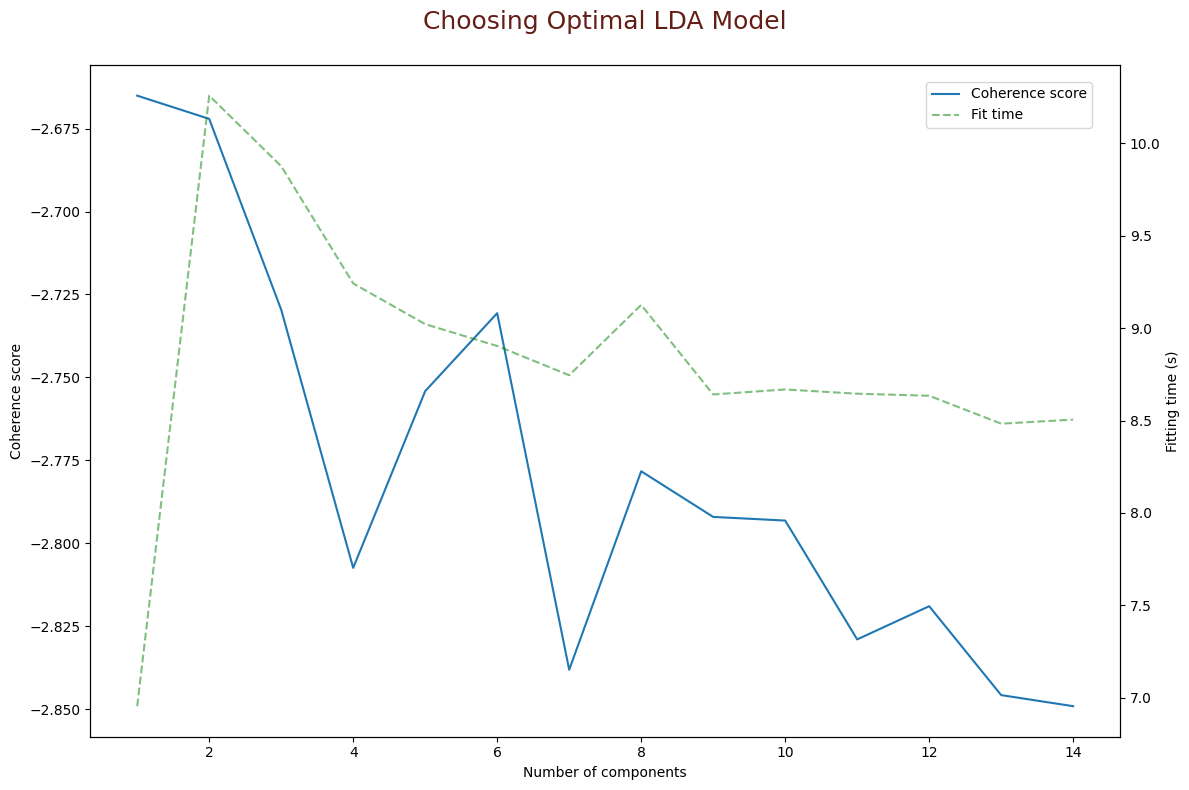

In [40]:
# Create dataframe of results
coherence_test = pd.DataFrame(coherence_test,
                              columns=["k","coherence","time"])

# Plot results
fig, ax1 = plt.subplots(figsize=(12,8))
x = coherence_test["k"]
y1 = coherence_test["coherence"]
y2 = coherence_test["time"]

ax1.plot(x, y1, label="Coherence score")
ax1.set_xlabel("Number of components")
ax1.set_ylabel("Coherence score")

ax2 = ax1.twinx()
ax2.plot(x, y2, label="Fit time",
         color='g', alpha=.5,
         linestyle='--')
ax2.set_ylabel("Fitting time (s)")

plt.title("Choosing Optimal LDA Model\n",
          color="#641E16", fontsize=18)
legend = fig.legend(loc=1, bbox_to_anchor=(.92, .9))

fig.tight_layout()
plt.show()

Nb de clusters (k) = 4.

In [41]:
# Build LDA model
best_lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=4,
                                  random_state=8,
                                  #per_word_topics=True,
                                  #workers=4
                                  )

In [42]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(best_lda_model, corpus, id2word, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.037745  0.008889       1        1  28.644162
2      0.013679  0.039378       2        1  26.165296
1      0.039831 -0.015824       3        1  23.980519
3     -0.015765 -0.032444       4        1  21.210023, topic_info=         Term         Freq        Total Category  logprob  loglift
2     réponse  2748.000000  2748.000000  Default  30.0000  30.0000
91    précise   306.000000   306.000000  Default  29.0000  29.0000
146  efficace   365.000000   365.000000  Default  28.0000  28.0000
11   recevoir   657.000000   657.000000  Default  27.0000  27.0000
69    attente  1221.000000  1221.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
70      appel   128.848130   701.039165   Topic4  -4.9832  -0.1432
18     mutuel   108.614278   442.413716   Topic4  -5.1540   0.1463
189   envoyer   111.611105   491.728619   Topic4  -5.1268   0.0678
25    accueil   118.191810   679.452172   Topic4  -5.0695  -0.1983
26        bon   114.917552   975.993075   Topic4  -5.0976  -0.5885

[336 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
936       1  0.633410  aboutir
936       2  0.219257  aboutir
936       3  0.024362  aboutir
936       4  0.146172  aboutir
937       1  0.182588   absent
...     ...       ...      ...
1800      3  0.214730  évaluer
1800      4  0.214730  évaluer
800       1  0.297268  évoquer
800       3  0.148634  évoquer
800       4  0.594536  évoquer

[829 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 4])

In [43]:
# Bigrams

def convertTuple(tup):
    str = ''
    for item in tup:
        str = str + ' ' + item
    return str
 

def traitement_n_grams(n, X):

    X_n_grams = [' '.join(map(str, l)) for l in X]
    n_grams = []
    for index, sentence in enumerate(X_n_grams):
        ngram = ngrams(X_n_grams[index].split(), n)
        for gram in ngram:
            n_grams.append(gram)

    # Df total n_grams
    occurrences = Counter(n_grams)
    df_ngrams = pd.DataFrame(data = [occurrences.keys(), occurrences.values()], index = [f"{n}gram", "occurrences"]).T

    # Plot 100 n_grams les plus communs
    df_ngrams_100 = df_ngrams.sort_values(by=["occurrences"], ascending=False)[:100]
    plt.subplots(figsize=(5, 14))
    plt.title(f'100 {n}grams les plus communs')
    sns.barplot(df_ngrams_100, x = "occurrences", y = f"{n}gram", orient = 'h')

    # WordCloud
    df_ngrams[f"{n}gram_str"] = df_ngrams[f"{n}gram"].apply(convertTuple) # Format str obligatoire, pas tuple
    occurrences_str = dict(zip(df_ngrams[f"{n}gram_str"], df_ngrams.occurrences))
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=occurrences_str)
    plt.subplots(figsize=(5, 14))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')

C:\ProgramData\Python38\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\ProgramData\Python38\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
C:\ProgramData\Python38\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\ProgramData\Python38\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transpose

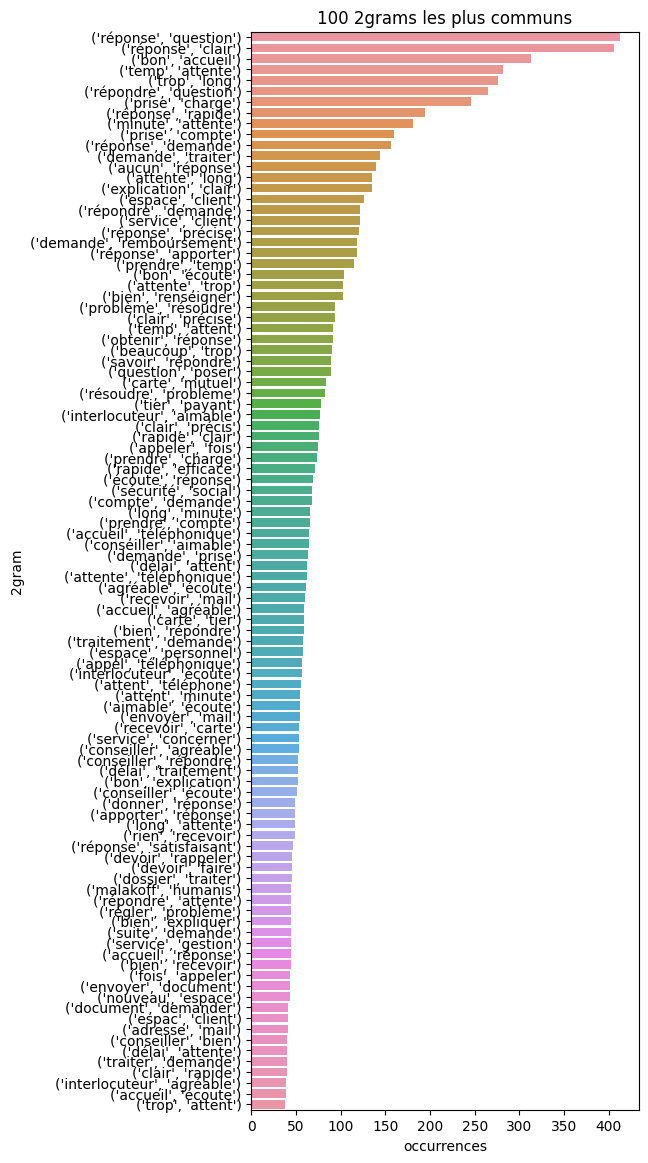

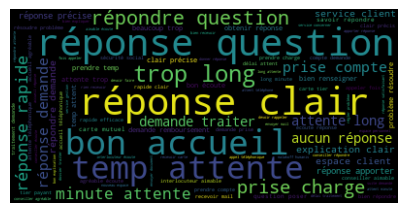

In [44]:
# Bigram 
traitement_n_grams(2, X)

C:\ProgramData\Python38\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\ProgramData\Python38\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
C:\ProgramData\Python38\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\ProgramData\Python38\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transpose

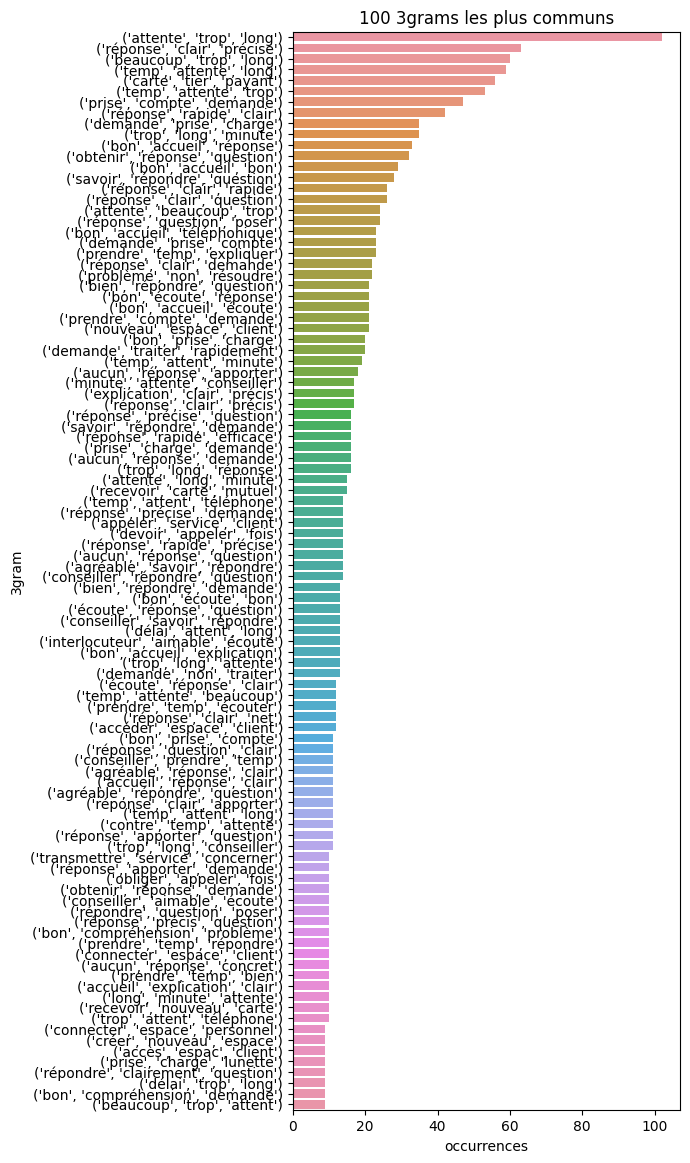

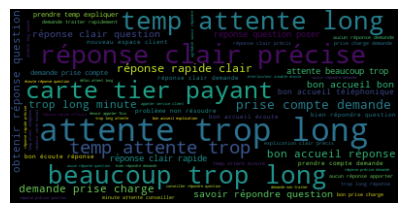

In [45]:
# Trigram 
traitement_n_grams(3, X)

In [46]:
### Filtre détracteurs

X = data.remerciements_token.loc[data.sat <= 2].dropna()

# Create dictionnary (bag of words)
id2word = corpora.Dictionary(X)
# On filtre les mots grâce à la fonction filter_extremes (ici les 60%)
id2word.filter_extremes(no_below=4, no_above=0.6, keep_n=None)
# Create Corpus 
texts = X  
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1)]]


In [47]:
# Iter LDA for best number of topics
coherence_test = []
for k in np.arange(1,15,1):
    print("Fitting LDA for K = {}".format(k))
    start_time = time.time()
    lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=k,
                                  random_state=8,
                                  per_word_topics=True,
                                  workers=4)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=texts,
                                         dictionary=id2word,
                                         coherence='u_mass')
    coherence_lda = coherence_model_lda.get_coherence()
    end_time = time.time()
    coherence_test.append((k, coherence_lda,
                           (end_time - start_time)))

Fitting LDA for K = 1
Fitting LDA for K = 2
Fitting LDA for K = 3
Fitting LDA for K = 4
Fitting LDA for K = 5
Fitting LDA for K = 6
Fitting LDA for K = 7
Fitting LDA for K = 8
Fitting LDA for K = 9
Fitting LDA for K = 10
Fitting LDA for K = 11
Fitting LDA for K = 12
Fitting LDA for K = 13
Fitting LDA for K = 14


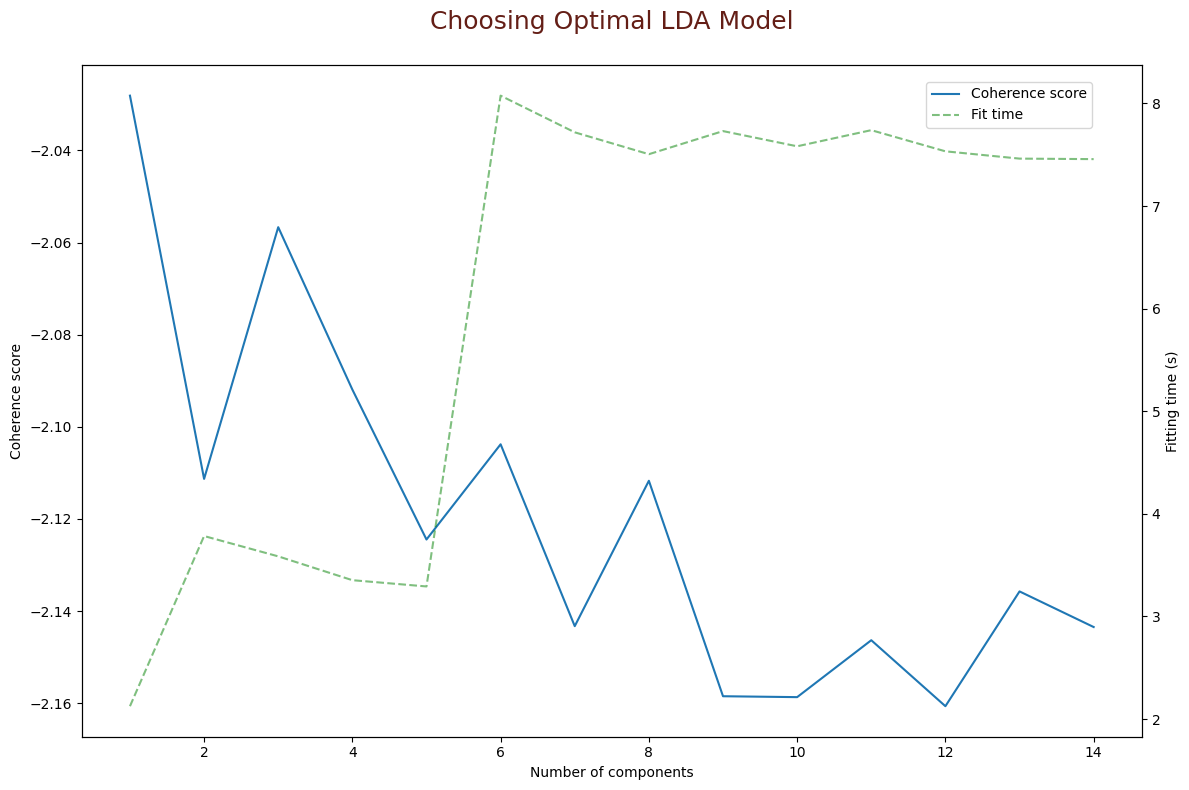

In [48]:
# Create dataframe of results
coherence_test = pd.DataFrame(coherence_test,
                              columns=["k","coherence","time"])

# Plot results
fig, ax1 = plt.subplots(figsize=(12,8))
x = coherence_test["k"]
y1 = coherence_test["coherence"]
y2 = coherence_test["time"]

ax1.plot(x, y1, label="Coherence score")
ax1.set_xlabel("Number of components")
ax1.set_ylabel("Coherence score")

ax2 = ax1.twinx()
ax2.plot(x, y2, label="Fit time",
         color='g', alpha=.5,
         linestyle='--')
ax2.set_ylabel("Fitting time (s)")

plt.title("Choosing Optimal LDA Model\n",
          color="#641E16", fontsize=18)
legend = fig.legend(loc=1, bbox_to_anchor=(.92, .9))

fig.tight_layout()
plt.show()

In [49]:
# Build LDA model
best_lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=corpus,
                                  id2word=id2word,
                                  num_topics=6,
                                  random_state=8,
                                  #per_word_topics=True,
                                  #workers=4
                                  )

In [50]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(best_lda_model, corpus, id2word, mds="mmds", R=30)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.009596  0.028361       1        1  18.707443
1     -0.016815 -0.039821       2        1  17.515248
4     -0.051429 -0.006101       3        1  17.419145
2     -0.027078  0.043678       4        1  16.481479
3      0.037076 -0.037901       5        1  15.494755
0      0.048651  0.011784       6        1  14.381929, topic_info=              Term        Freq       Total Category  logprob  loglift
143        demande  630.000000  630.000000  Default  30.0000  30.0000
54         attente  327.000000  327.000000  Default  29.0000  29.0000
50            mois  335.000000  335.000000  Default  28.0000  28.0000
45         dossier  263.000000  263.000000  Default  27.0000  27.0000
136           rien  226.000000  226.000000  Default  26.0000  26.0000
..             ...         ...         ...      ...      ...      ...
117          aucun   36.948079  411.066097   Topic6  -4.7454  -0.4700
188     traitement   22.012918  111.722492   Topic6  -5.2632   0.3148
107  remboursement   27.501016  340.891276   Topic6  -5.0407  -0.5781
189        traiter   24.643501  209.183371   Topic6  -5.1504  -0.1995
72           faire   26.222205  303.568461   Topic6  -5.0883  -0.5098

[461 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
804       1  0.147064    accepter
804       3  0.147064    accepter
804       4  0.147064    accepter
804       5  0.441191    accepter
1016      1  0.172267    accident
...     ...       ...         ...
192       5  0.151821      équipe
774       1  0.153088  évidemment
774       2  0.153088  évidemment
774       4  0.459265  évidemment
774       6  0.153088  évidemment

[1381 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 5, 3, 4, 1])

C:\ProgramData\Python38\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\ProgramData\Python38\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
C:\ProgramData\Python38\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\ProgramData\Python38\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transpose

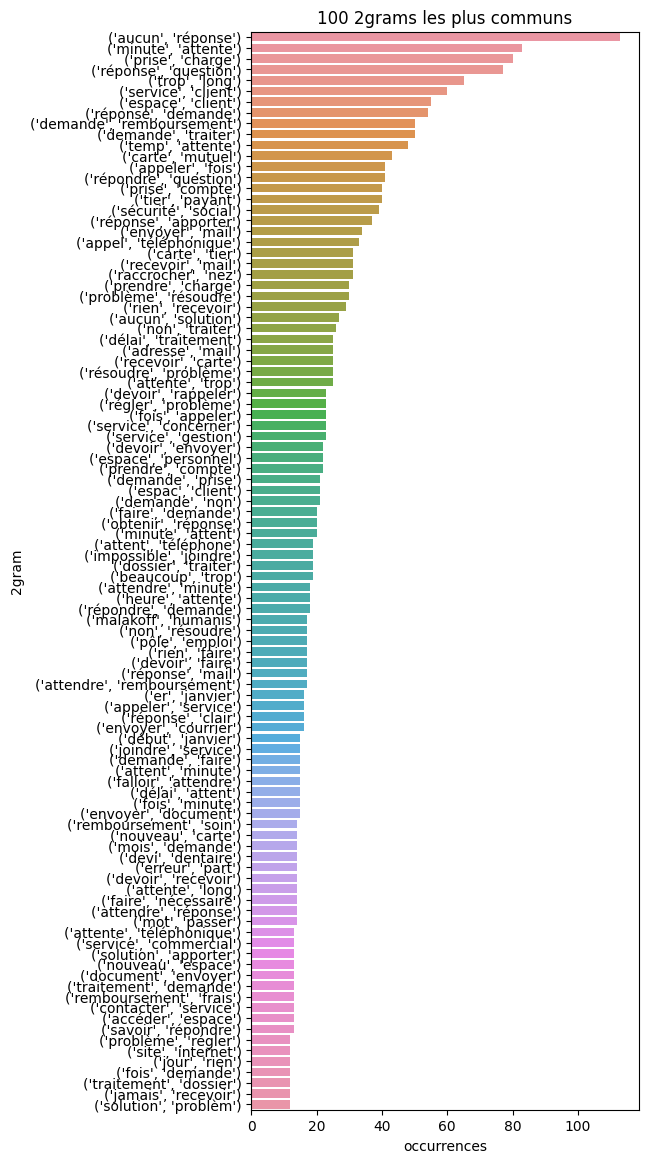

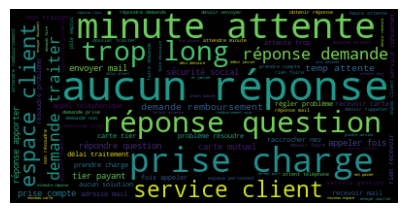

In [51]:
# Bigram detracteurs
traitement_n_grams(2, X)

C:\ProgramData\Python38\lib\site-packages\wordcloud\wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
C:\ProgramData\Python38\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\ProgramData\Python38\lib\site-packages\wordcloud\wordcloud.py:520: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
C:\ProgramData\Python38\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
C:\ProgramData\Python38\lib\site-packages\wordcloud\wordclo

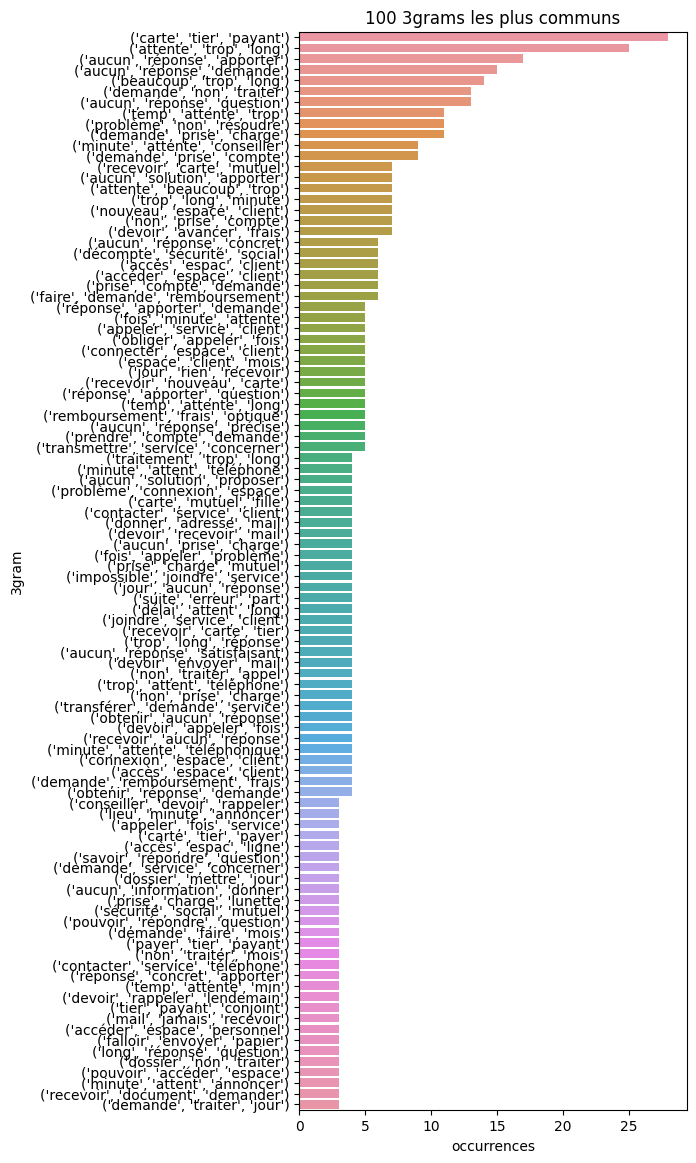

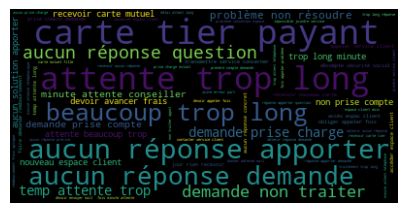

In [52]:
# Trigram detracteurs
traitement_n_grams(3, X)

In [53]:
https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/

SyntaxError: invalid syntax (1254716489.py, line 1)